In [36]:
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# HypeParameters
input=28*28
input_size = input
num_classes = 10
num_epochs = 10
hidden_size = 500
batch_size = 128
learning_rate = 0.0001

In [ ]:
#Data-loading
train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True,
transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False,
transform=transforms.ToTensor(),download=True)
train_loader = torch.utils.data.DataLoader(dataset=(train_dataset),
batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=(test_dataset) ,
batch_size=batch_size,shuffle=False)
###########################################
def create_datasets(batch_size):
# percentage of training set to use as validation
  valid_size = 0.15
# convert data to torch.FloatTensor
  transform = transforms.ToTensor()
# choose the training and test datasets
  train_data = datasets.FashionMNIST(root='data',train=True,download=True,
                              transform=transform)
  test_data = datasets.FashionMNIST(root='data',train=False,download=True,
                             transform=transform)
  # obtain training indices that will be used for validation
  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]
  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  # load training data in batches
  train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
  sampler=train_sampler,num_workers=0)
  # load validation data in batches
  valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
  sampler=valid_sampler,num_workers=0)
  # load test data in batches
  test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,
  num_workers=0)
  return train_loader, test_loader, valid_loader

In [ ]:
# example = iter(train_loader)
# example
# example_data, example_targ = example.next()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.imshow(example_data[i][0])
#   plt.show()
#pick a sample to plot

sample = 3
image = train_dataset[3][0][0]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [40]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.input_size = input_size
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, math.floor(hidden_size/2))
    self.l3 = nn.Linear(math.floor(hidden_size/2), num_classes)
    self.N=nn.Softmax()
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    # no activation and no softmax at the end
    return out
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)


NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=250, bias=True)
  (l3): Linear(in_features=250, out_features=10, bias=True)
  (N): Softmax(dim=None)
)


Epoch [1/10], Step [100/469], Loss: 0.8947812914848328
Epoch [1/10], Step [200/469], Loss: 0.7380427122116089
Epoch [1/10], Step [300/469], Loss: 0.6428419351577759
Epoch [1/10], Step [400/469], Loss: 0.513683021068573
Epoch [2/10], Step [100/469], Loss: 0.49215883016586304
Epoch [2/10], Step [200/469], Loss: 0.42894595861434937
Epoch [2/10], Step [300/469], Loss: 0.360217422246933
Epoch [2/10], Step [400/469], Loss: 0.47549620270729065
Epoch [3/10], Step [100/469], Loss: 0.5738204121589661
Epoch [3/10], Step [200/469], Loss: 0.4235231876373291
Epoch [3/10], Step [300/469], Loss: 0.5362973809242249
Epoch [3/10], Step [400/469], Loss: 0.3853635787963867
Epoch [4/10], Step [100/469], Loss: 0.3558949828147888
Epoch [4/10], Step [200/469], Loss: 0.49537286162376404
Epoch [4/10], Step [300/469], Loss: 0.35782068967819214
Epoch [4/10], Step [400/469], Loss: 0.4016790986061096
Epoch [5/10], Step [100/469], Loss: 0.41262832283973694
Epoch [5/10], Step [200/469], Loss: 0.32114177942276
Epoch [5

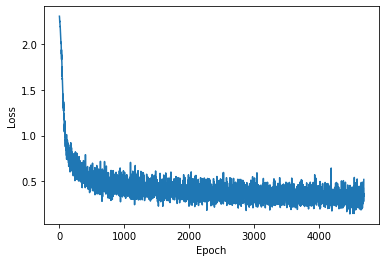

In [41]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)
Loss=[]
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [100, 1, 28, 28]
    # resized: [100, 784]
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    if (i+1) % 100 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}')

plt.plot(Loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test i```mages: {acc} %')

In [43]:
del model
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.input_size = input_size
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, math.floor(hidden_size/2))
    self.BN= nn.BatchNorm1d(math.floor(hidden_size/2))
    self.D0=nn.Dropout(0.05)
    self.D1=nn.Dropout(0.15)
    self.l3 = nn.Linear(math.floor(hidden_size/2), num_classes*2)
    self.BN2= nn.BatchNorm1d(num_classes*2)
    self.l4 = nn.Linear(num_classes*2, num_classes)
    self.N=nn.Softmax()
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out= self.D0(out)
    out = self.l2(out)
    out= self.BN(out)
    out = self.relu(out)
    out= self.D1(out)
    out = self.l3(out)
    out = self.relu(out)
    out= self.BN2(out)
    out = self.relu(out)
    out = self.l4(out)
    # no activation and no softmax at the end
    return out
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)


NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=250, bias=True)
  (BN): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D0): Dropout(p=0.05, inplace=False)
  (D1): Dropout(p=0.15, inplace=False)
  (l3): Linear(in_features=250, out_features=20, bias=True)
  (BN2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=20, out_features=10, bias=True)
  (N): Softmax(dim=None)
)


Epoch [1/10], Step [100/469], Loss: 1.4218800067901611
Epoch [1/10], Step [200/469], Loss: 1.328701138496399
Epoch [1/10], Step [300/469], Loss: 1.1972815990447998
Epoch [1/10], Step [400/469], Loss: 1.1386239528656006
Epoch [2/10], Step [100/469], Loss: 0.9976623058319092
Epoch [2/10], Step [200/469], Loss: 0.9992952942848206
Epoch [2/10], Step [300/469], Loss: 0.8878344297409058
Epoch [2/10], Step [400/469], Loss: 0.744052529335022
Epoch [3/10], Step [100/469], Loss: 0.659353494644165
Epoch [3/10], Step [200/469], Loss: 0.7189027667045593
Epoch [3/10], Step [300/469], Loss: 0.5576114058494568
Epoch [3/10], Step [400/469], Loss: 0.6361163258552551
Epoch [4/10], Step [100/469], Loss: 0.6345592737197876
Epoch [4/10], Step [200/469], Loss: 0.5662624835968018
Epoch [4/10], Step [300/469], Loss: 0.4833127558231354
Epoch [4/10], Step [400/469], Loss: 0.44945552945137024
Epoch [5/10], Step [100/469], Loss: 0.47366857528686523
Epoch [5/10], Step [200/469], Loss: 0.44342800974845886
Epoch [5/1

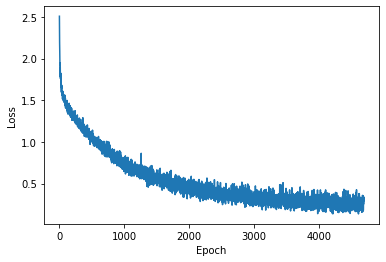

In [44]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)
Loss2=[]
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        outputsval = model(images)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Loss2.append(loss.item())
        if (i+1) % 100 == 0:
            
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}')
plt.plot(Loss2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
 # Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples= 0
    for images, labels in test_loader:
        
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
    # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    acc= 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
    #89.18

In [ ]:
plt.plot(Loss)
plt.plot(Loss2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
del model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)


In [48]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [49]:
def train_model(model, batch_size, patience, n_epochs):
    
      # to track the training loss as the model trains
    train_losses = []
  # to track the validation loss as the model trains
    valid_losses = []
  # to track the average training loss per epoch as the model trains
    avg_train_losses = []
  # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
  # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True) 
    for epoch in range( n_epochs ):
    ###################
    # train the model #
    ###################
        model.train() # prep model for training
    #for i, (images, labels) in enumerate(train_loader):
        for batch, (data, target) in enumerate(train_loader,1):
      # clear the gradients of all optimized variables
            data = data.reshape(-1, 28*28).to(device)
            target = target.to(device)
            optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
      # calculate the loss
            loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
      # perform a single optimization step (parameter update)
            optimizer.step()
      # record training loss
            train_losses.append(loss.item())
    ######################
    # validate the model #
    ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data = data.reshape(-1, 28*28).to(device)
            target = target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
          # calculate the loss
            loss = criterion(output, target)
          # record validation loss
            valid_losses.append(loss.item())
    # print training/validation statistics
    # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len+1}}/{n_epochs:>{epoch_len}}] ' +
        f'train_loss: {train_loss:.5f} ' +
        f'valid_loss: {valid_loss:.5f}')
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
  # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    return model, avg_train_losses, avg_valid_losses


In [50]:
batch_size = batch_size
n_epochs = num_epochs+10
train_loader, test_loader, valid_loader = create_datasets(batch_size)
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs) 

[  0/20] train_loss: 1.39302 valid_loss: 1.14864
Validation loss decreased (inf --> 1.148640).  Saving model ...
[  1/20] train_loss: 1.01878 valid_loss: 0.85931
Validation loss decreased (1.148640 --> 0.859313).  Saving model ...
[  2/20] train_loss: 0.77900 valid_loss: 0.66929
Validation loss decreased (0.859313 --> 0.669292).  Saving model ...
[  3/20] train_loss: 0.61102 valid_loss: 0.53911
Validation loss decreased (0.669292 --> 0.539113).  Saving model ...
[  4/20] train_loss: 0.50201 valid_loss: 0.47235
Validation loss decreased (0.539113 --> 0.472352).  Saving model ...
[  5/20] train_loss: 0.42652 valid_loss: 0.40908
Validation loss decreased (0.472352 --> 0.409075).  Saving model ...
[  6/20] train_loss: 0.37405 valid_loss: 0.37602
Validation loss decreased (0.409075 --> 0.376016).  Saving model ...
[  7/20] train_loss: 0.33344 valid_loss: 0.34360
Validation loss decreased (0.376016 --> 0.343605).  Saving model ...
[  8/20] train_loss: 0.30248 valid_loss: 0.32122
Validation l

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [52]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
  if len(target.data) != batch_size:
    break
  data = data.reshape(-1, 28*28).to(device)
  target = target.to(device)
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(data)
  # calculate the loss
  loss = criterion(output, target)
  # update test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct = np.squeeze(pred.eq(target.data.view_as(pred)))
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
    str(i), 100 * class_correct[i] / class_total[i],
    np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %5d%% (%5d/%5d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.311435

Test Accuracy of     0: 78% (788/1000)
Test Accuracy of     1: 97% (976/997)
Test Accuracy of     2: 81% (812/999)
Test Accuracy of     3: 90% (906/999)
Test Accuracy of     4: 78% (789/999)
Test Accuracy of     5: 96% (967/997)
Test Accuracy of     6: 75% (756/999)
Test Accuracy of     7: 97% (970/999)
Test Accuracy of     8: 97% (975/997)
Test Accuracy of     9: 96% (965/998)

Test Accuracy (Overall):    89% ( 8904/ 9984)
